In [1]:
from transformers import BertForQuestionAnswering, BertTokenizerFast, Trainer, TrainingArguments
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt

# Load SQuAD dataset
dataset = load_dataset("squad")

# Load Model and Tokenizer
model_name = "bert-base-cased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = BertForQuestionAnswering.from_pretrained(model_name)

# Load and preprocess a smaller subset of the dataset
dataset = load_dataset("squad")
small_train_dataset = dataset["train"].shuffle(seed=42).select(range(1000))  # Select first 1000 examples
small_val_dataset = dataset["validation"].shuffle(seed=42).select(range(200))  # Select first 200 examples

# Preprocessing function with reduced max_length
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        truncation=True,
        max_length=128,  # Reduced sequence length
        padding="max_length",
        return_offsets_mapping=True,
    )
    start_positions = []
    end_positions = []

    for i, offsets in enumerate(inputs["offset_mapping"]):
        # Get answer text and start index
        answer = examples["answers"][i]
        if len(answer["answer_start"]) == 0:
            # No answer case
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Answer exists
            start_char = answer["answer_start"][0]
            end_char = start_char + len(answer["text"][0])
            sequence_ids = inputs.sequence_ids(i)

            # Initialize token indices
            token_start = None
            token_end = None

            # Loop through offsets to find matching token indices
            for idx, offset in enumerate(offsets):
                if sequence_ids[idx] == 1:  # Context tokens
                    if offset[0] <= start_char < offset[1]:
                        token_start = idx
                    if offset[0] < end_char <= offset[1]:
                        token_end = idx
                        break

            # Use 0 as default if no match found
            start_positions.append(token_start if token_start is not None else 0)
            end_positions.append(token_end if token_end is not None else 0)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    inputs.pop("offset_mapping", None)  # Remove offset mapping as it's not needed for training
    return inputs


2025-01-20 22:29:42.247005: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-20 22:29:42.341397: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-20 22:29:42.751012: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-01-20 22:29:42.751067: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

  0%|          | 0/2 [00:00<?, ?it/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Reusing dataset squad (/home/viorel/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /home/viorel/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-10de9997c4b83f65.arrow
Loading cached shuffled indices for dataset at /home/viorel/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-f3a033b6ac26514f.arrow


In [2]:
# Tokenize datasets
tokenized_train = small_train_dataset.map(preprocess_function, batched=True, remove_columns=small_train_dataset.column_names)
tokenized_val = small_val_dataset.map(preprocess_function, batched=True, remove_columns=small_val_dataset.column_names)


Parameter 'function'=<function preprocess_function at 0x74ea6d93d870> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [3]:
from transformers import TrainerCallback

class EvalLossTracker(TrainerCallback):
    def __init__(self):
        self.eval_losses = []

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if "eval_loss" in metrics:
            self.eval_losses.append(metrics["eval_loss"])

    def get_eval_losses(self):
        return self.eval_losses

In [4]:
import keras
import tensorflow as tf
from transformers import TrainingArguments, Trainer

# Define training arguments for faster training
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,  # Larger batch size
    per_device_eval_batch_size=16,
    num_train_epochs=1,  # Fewer epochs
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    gradient_accumulation_steps=1,
    fp16=True,  # Enable mixed precision
)


/home/viorel/.local/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [7]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Instantiate the callback
eval_loss_tracker = EvalLossTracker()


# Update Trainer to ensure proper device usage
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer, # Pass the tokenizer (recommended for Trainer)
    callbacks=[eval_loss_tracker]
)

# Fine-tune the model
trainer.train()

# Evaluate the model
metrics = trainer.evaluate()
print(metrics)

/tmp/ipykernel_1617001/3596299630.py:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,3.122100,3.100909


{'eval_loss': 3.1009087562561035, 'eval_runtime': 0.8085, 'eval_samples_per_second': 247.377, 'eval_steps_per_second': 16.079, 'epoch': 1.0}


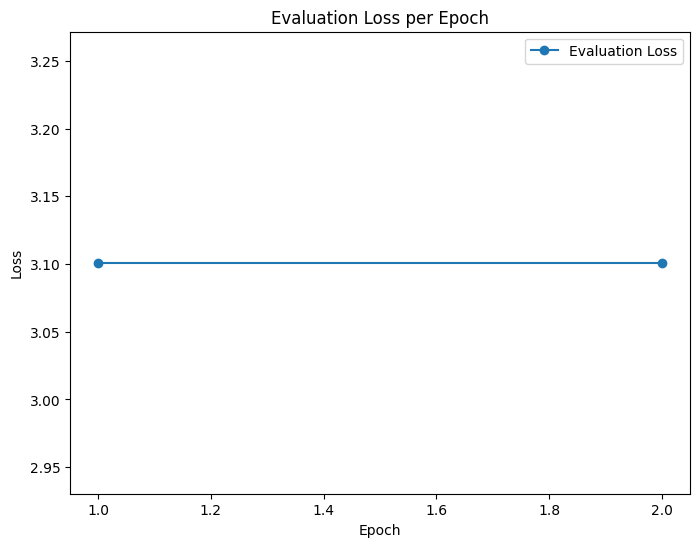

In [8]:
# Get the eval losses from the callback
eval_losses = eval_loss_tracker.get_eval_losses()

# Function to plot evaluation losses
def plot_accuracy(eval_losses):
    if not eval_losses:
        print("No evaluation loss data available for plotting.")
        return

    epochs = range(1, len(eval_losses) + 1)
    
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, eval_losses, label="Evaluation Loss", marker="o")
    plt.title("Evaluation Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Plot the evaluation loss
plot_accuracy(eval_losses)
